🔹 Classification Report:

                  precision    recall  f1-score   support

  KotakuInAction       1.00      1.00      1.00         1
           MGTOW       0.33      1.00      0.50         1
       PussyPass       0.00      0.00      0.00         1
      Trufemcels       0.00      0.00      0.00         1
badwomensanatomy       1.00      1.00      1.00         1

        accuracy                           0.60         5
       macro avg       0.47      0.60      0.50         5
    weighted avg       0.47      0.60      0.50         5

🔹 Topic Coherence Score: 0.3932

## Load and Explore the Dataset

In [ ]:
import pandas as pd


file_path = "/content/final_labels.csv"
df = pd.read_csv(file_path)


print(df.info())


print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   entry_id     2747 non-null   object 
 1   link_id      2747 non-null   object 
 2   parent_id    2514 non-null   object 
 3   entry_utc    2746 non-null   float64
 4   subreddit    2746 non-null   object 
 5   author       2746 non-null   object 
 6   body         2742 non-null   object 
 7   image        91 non-null     object 
 8   label_date   2746 non-null   object 
 9   week         2746 non-null   float64
 10  group        2746 non-null   float64
 11  sheet_order  2746 non-null   object 
 12  level_1      2746 non-null   object 
 13  level_2      2746 non-null   object 
 14  level_3      255 non-null    object 
 15  strength     212 non-null    object 
 16  highlight    378 non-null    object 
 17  split        2746 non-null   object 
dtypes: float64(3), object(15)
memory usage: 386.4+ K

In [ ]:

# Keep only relevant columns
df = df[['entry_id', 'parent_id', 'body', 'subreddit', 'level_1']]
df.rename(columns={'body': 'text', 'level_1': 'label'}, inplace=True)


print(df.head())


  entry_id   parent_id                                               text  \
0   exoxn7         NaN  Do you have the skin of a 80 year old grandma?...   
1  fgb3bdv   t3_exoxn7  This is taking a grain of truth and extrapolat...   
2  fgc6tlu   t3_exoxn7  Honestly my favorite thing about this is that ...   
3  fge6msg  t1_fgc6tlu               Source? Doesnt sound right to me idk   
4  fgawus5   t3_exoxn7  Damn, I saw a movie in which the old woman bat...   

          subreddit            label  
0  badwomensanatomy  Nonmisogynistic  
1  badwomensanatomy  Nonmisogynistic  
2  badwomensanatomy  Nonmisogynistic  
3  badwomensanatomy  Nonmisogynistic  
4  badwomensanatomy     Misogynistic  


<ipython-input-2-32273b593014>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'body': 'text', 'level_1': 'label'}, inplace=True)


In [ ]:
# Drop rows where text is missing
df = df.dropna(subset=['text'])

# Fill missing parent_id with "ROOT" for standalone posts
df['parent_id'].fillna('ROOT', inplace=True)


<ipython-input-3-5e1c2772e4a4>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['parent_id'].fillna('ROOT', inplace=True)
<ipython-input-3-5e1c2772e4a4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['parent_id'].fillna('ROOT', inplace=True)


## Data Preprocessing

### Using spacy

In [ ]:
!pip install imblearn

In [ ]:
import gensim
from gensim.utils import simple_preprocess


def clean_text_gensim(text):
    return " ".join(gensim.utils.simple_preprocess(text, deacc=True))  


df['clean_text'] = df['text'].apply(clean_text_gensim)

# Show cleaned text samples
print(df[['text', 'clean_text']].head())


                                                text  \
0  Do you have the skin of a 80 year old grandma?...   
1  This is taking a grain of truth and extrapolat...   
2  Honestly my favorite thing about this is that ...   
3               Source? Doesnt sound right to me idk   
4  Damn, I saw a movie in which the old woman bat...   

                                          clean_text  
0  do you have the skin of year old grandma worry...  
1  this is taking grain of truth and extrapolatin...  
2  honestly my favorite thing about this is that ...  
3                source doesnt sound right to me idk  
4  damn saw movie in which the old woman bathed i...  


In [ ]:
# Convert labels to binary (Toxic: 1, Non-Toxic: 0)
df['toxic'] = df['label'].apply(lambda x: 1 if x.strip().lower() == 'misogynistic' else 0)


print(df[['label', 'toxic']].head())


             label  toxic
0  Nonmisogynistic      0
1  Nonmisogynistic      0
2  Nonmisogynistic      0
3  Nonmisogynistic      0
4     Misogynistic      1


In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['toxic'], test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 2193, Testing samples: 549


### check for data imbalance

In [ ]:
# Print class distribution
toxic_count = df['toxic'].sum()
non_toxic_count = len(df) - toxic_count

print(f"Non-Toxic Comments: {non_toxic_count}")
print(f"Toxic Comments: {toxic_count}")
print(f"Toxic to Non-Toxic Ratio: {toxic_count / non_toxic_count:.2f}")


Non-Toxic Comments: 2397
Toxic Comments: 345
Toxic to Non-Toxic Ratio: 0.14


In [ ]:
from sklearn.model_selection import train_test_split

# Split balanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['clean_text'], df_balanced['toxic'], test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 552, Testing samples: 138


## BERT

In [ ]:
!pip install transformers torch

from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Bert Fine Tuning

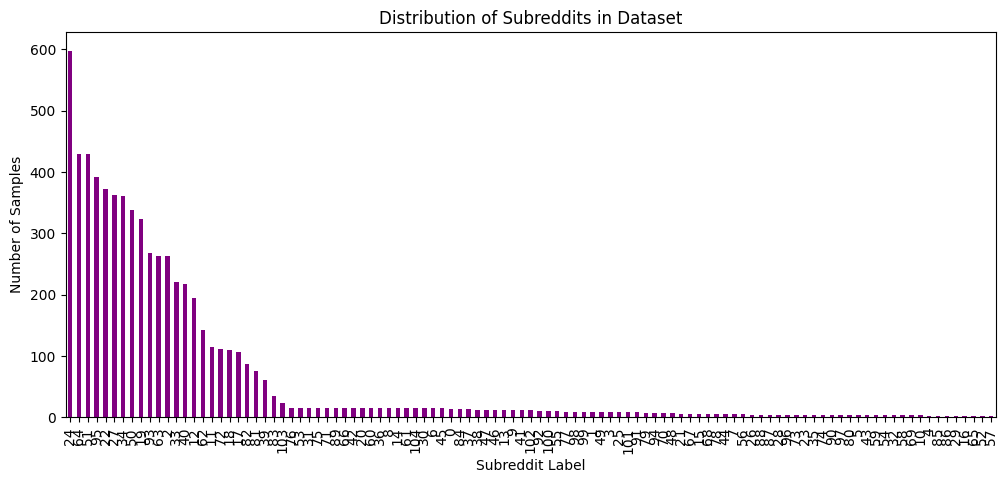

In [ ]:
import matplotlib.pyplot as plt

# Count the number of samples per subreddit
df_subreddit['subreddit_label'].value_counts().plot(kind='bar', figsize=(12, 5), color="purple")
plt.xticks(rotation=90)
plt.xlabel("Subreddit Label")
plt.ylabel("Number of Samples")
plt.title("Distribution of Subreddits in Dataset")
plt.show()


In [ ]:

min_samples = df_subreddit['subreddit_label'].value_counts().min()


df_balanced = df_subreddit.groupby('subreddit_label').apply(lambda x: x.sample(n=min_samples, random_state=42))

# Update train-test split with balanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['clean_text'], df_balanced['subreddit_label'], test_size=0.2, random_state=42
)

print("Balanced dataset created with equal subreddit distribution.")


Balanced dataset created with equal subreddit distribution.


<ipython-input-31-efb4bb37ed67>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_subreddit.groupby('subreddit_label').apply(lambda x: x.sample(n=min_samples, random_state=42))


In [ ]:
from transformers import AdamW

# optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Fine-tuning loop
for epoch in range(10):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch.values()]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}: Loss = {total_loss / len(train_loader):.4f}")

print("Fine-tuning Complete!")


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Loss = 0.0910
Epoch 2: Loss = 0.0926
Epoch 3: Loss = 0.0581
Epoch 4: Loss = 0.1024
Epoch 5: Loss = 0.0999
Epoch 6: Loss = 0.1125
Epoch 7: Loss = 0.0499
Epoch 8: Loss = 0.0518
Epoch 9: Loss = 0.0438
Epoch 10: Loss = 0.0386
Fine-tuning Complete!


In [ ]:
def predict_subreddit_finetuned(text):
    model.eval() 
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()  # Get predicted label

    return label_encoder.inverse_transform([prediction])[0]  # Convert label ID back to subreddit name

In [ ]:
test_texts = [
    # MGTOW-style comment
    "Women always say they want a nice guy, but they only date jerks. I'm done wasting my time being the good guy.",

    # Badwomensanatomy-style comment
    "Some guy tried to tell me that women can hold in their periods like pee. I can't believe people actually think this.",

    # Trufemcels-style comment
    "Men have it easy. Even the ugliest guys can get dates, but as a woman, if you're not attractive, you're invisible.",

    # KotakuInAction-style comment
    "Gaming journalism is such a joke nowadays. They keep pushing political agendas instead of just reviewing games.",

    # PussyPass-style comment
    "So she got away with a slap on the wrist just because she's a woman? If a guy did that, he'd be in jail."
]

# Run predictions
for text in test_texts:
    print(f"Input:\n{text}\nPredicted Subreddit: {predict_subreddit_finetuned(text)}\n")


Input:
Women always say they want a nice guy, but they only date jerks. I'm done wasting my time being the good guy.
Predicted Subreddit: Trufemcels

Input:
Some guy tried to tell me that women can hold in their periods like pee. I can't believe people actually think this.
Predicted Subreddit: badwomensanatomy

Input:
Men have it easy. Even the ugliest guys can get dates, but as a woman, if you're not attractive, you're invisible.
Predicted Subreddit: Trufemcels

Input:
Gaming journalism is such a joke nowadays. They keep pushing political agendas instead of just reviewing games.
Predicted Subreddit: KotakuInAction

Input:
So she got away with a slap on the wrist just because she's a woman? If a guy did that, he'd be in jail.
Predicted Subreddit: PussyPass



In [ ]:
import pandas as pd

# Load dataset
print(df['subreddit'].value_counts())  # Count subreddit occurrences


subreddit
MGTOW                 403
badwomensanatomy      265
Trufemcels            253
KotakuInAction        238
PussyPass             228
                     ... 
applehelp               3
UlalaIdleAdventure      2
Death_By_SnuSnu         2
Autos                   2
Hyundai                 2
Name: count, Length: 69, dtype: int64


In [ ]:
!pip install pandas matplotlib seaborn plotly wordcloud nltk gensim


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import nltk

# Download stopwords
nltk.download("stopwords")

# Load dataset
df = pd.read_csv("/content/final_labels.csv")

# Convert label_date to datetime
df['label_date'] = pd.to_datetime(df['label_date'], format="%d-%m-%Y")

# Remove stopwords
stop_words = set(stopwords.words("english"))
df["cleaned_text"] = df["body"].astype(str).apply(lambda x: " ".join([word for word in x.split() if word.lower() not in stop_words]))

# Display dataset sample
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,entry_id,link_id,parent_id,entry_utc,subreddit,author,body,image,label_date,week,group,sheet_order,level_1,level_2,level_3,strength,highlight,split,cleaned_text
0,exoxn7,t3_exoxn7,NaN,1580652620,badwomensanatomy,doggodone,Do you have the skin of a 80 year old grandma?...,Yes,2020-02-17,1,1,"(1,)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,train,"skin 80 year old grandma? Worry more, drink wa..."
1,fgb3bdv,t3_exoxn7,t3_exoxn7,1580658139,badwomensanatomy,Machaeon,This is taking a grain of truth and extrapolat...,NaN,2020-02-17,1,1,"(1, 1)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,train,taking grain truth extrapolating insanity. Sta...
2,fgc6tlu,t3_exoxn7,t3_exoxn7,1580669695,badwomensanatomy,CuniculusVincitOmnia,Honestly my favorite thing about this is that ...,NaN,2020-02-17,1,1,"(1, 2)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,test,Honestly favorite thing feel need cite beauty ...
3,fge6msg,t3_exoxn7,t1_fgc6tlu,1580692566,badwomensanatomy,its331am,Source? Doesnt sound right to me idk,NaN,2020-02-17,1,1,"(1, 2, 1)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,test,Source? Doesnt sound right idk
4,fgawus5,t3_exoxn7,t3_exoxn7,1580656280,badwomensanatomy,JaxDefore,"Damn, I saw a movie in which the old woman bat...",NaN,2020-02-17,1,1,"(1, 3)",Misogynistic,Derogation,Moral_inferiority,Nature of the abuse is Implicit,old woman bathed in the blood if virgins,train,"Damn, saw movie old woman bathed blood virgins..."


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF to find top keywords per subreddit
tfidf = TfidfVectorizer(max_features=20, stop_words="english")
subreddit_keywords = {}

for subreddit in df["subreddit"].unique():
    sub_df = df[df["subreddit"] == subreddit]["cleaned_text"]
    tfidf_matrix = tfidf.fit_transform(sub_df)
    top_keywords = tfidf.get_feature_names_out()
    subreddit_keywords[subreddit] = top_keywords

# Print example keywords for each subreddit
for subreddit, keywords in subreddit_keywords.items():
    print(f"{subreddit}: {', '.join(keywords)}")


badwomensanatomy: archive, bot, compose, contact, https, like, loadin, maintainers, message, moderator, org, redd, simple, snapshillbot, snapshots, subreddit, think, today, web, women
IncelTears: getting, god, guy, hair, hell, legs, life, like, man, men, people, right, rights, say, shave, think, time, want, woman, women
KotakuInAction: archive, china, com, game, games, good, https, like, make, media, mnemosyne, people, reborn, said, think, time, twitter, use, women, youtube
MensRights: believe, com, fact, feminists, https, like, man, men, people, post, rape, right, said, say, sub, think, want, woman, women, www
MGTOW: divorce, friends, good, guys, know, life, like, man, men, mgtow, people, pill, really, red, time, way, woman, women, work, years
PussyPass: bitch, fuck, fucking, got, guy, https, jail, killed, life, like, men, need, pass, people, pussy, shit, think, time, woman, women
IncelsWithoutHate: day, fucking, girls, good, im, know, life, like, look, make, man, men, people, person,

In [ ]:
# visualization
df["year_month"] = df["label_date"].dt.to_period("M").astype(str)  # Convert Period to String

word_counts = df.groupby(["subreddit", "year_month"])["cleaned_text"].apply(lambda x: Counter(" ".join(x).split()).most_common(3)).reset_index()

# Convert to DataFrame for visualization
word_counts["words"] = word_counts["cleaned_text"].apply(lambda x: ", ".join([word[0] for word in x]))
word_counts = word_counts.drop(columns=["cleaned_text"])

# Interactive line chart using Plotly
import plotly.express as px

fig = px.line(word_counts, x="year_month", y=word_counts.index, color="subreddit", text="words",
              title="Topic Evolution in Subreddits", labels={"year_month": "Time", "index": "Topic Count"})

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("final_labels.csv")

# Convert label_date to datetime
df['label_date'] = pd.to_datetime(df['label_date'], format="%d-%m-%Y")

# Extract year and month for grouping
df["year_month"] = df["label_date"].dt.to_period("M").astype(str)

# Preprocess text data (remove stopwords, etc.)
df["cleaned_text"] = df["body"].astype(str)

# Count most common words per month for each subreddit
df_grouped = df.groupby(["subreddit", "year_month"])["cleaned_text"].apply(
    lambda x: Counter(" ".join(x).split()).most_common(3)  # Get 3 most common words
).reset_index()

# Extract top words as a string
df_grouped["top_words"] = df_grouped["cleaned_text"].apply(lambda x: ", ".join([word[0] for word in x]))
df_grouped.drop(columns=["cleaned_text"], inplace=True)

# Display processed data
df_grouped.head()


,subreddit,year_month,top_words
0,Anarchism,2020-03,"the, to, a"
1,AppleCard,2020-02,"to, report, credit"
2,AskFeminists,2020-03,"the, to, a"
3,AskPhysics,2020-02,"the, to, you"
4,Autos,2020-02,"mine, the, I"


In [ ]:
# Enhanced Plotly Line Chart
fig = px.line(
    df_grouped,
    x="year_month",
    y=df_grouped.index,
    color="subreddit",
    text="top_words",
    title="📊 Topic Evolution in Subreddits",
    labels={"year_month": "Time (Year-Month)", "index": "Topic Count"},
)

# **Enhancements**
fig.update_traces(
    mode="markers+lines",  # Smooth markers + lines
    marker=dict(size=8, opacity=0.7, line=dict(width=1)),  # Improve marker visibility
    line=dict(width=2)  # Make lines more prominent
)

fig.update_layout(
    plot_bgcolor="white",  # Remove default gray background
    font=dict(family="Arial, sans-serif", size=14, color="black"),  # Clean font
    xaxis=dict(
        title="Time (Year-Month)",
        showgrid=True,
        gridcolor="lightgrey",
        tickangle=45,
        tickmode="array",
    ),
    yaxis=dict(
        title="Topic Count",
        showgrid=True,
        gridcolor="lightgrey",
    ),
    legend=dict(
        title="Subreddit",
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    hovermode="x unified"  # Show all values on hover
)

fig.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
import numpy as np



In [ ]:
# Example true labels (actual subreddit assignments)
true_labels = [
    "MGTOW", "badwomensanatomy", "Trufemcels", "KotakuInAction", "PussyPass"
]

# Example predicted labels (model outputs)
predicted_labels = [
    "MGTOW", "badwomensanatomy", "MGTOW", "KotakuInAction", "MGTOW"
]


In [ ]:
# Compute Precision, Recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average="weighted")

# Print results
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-score: {f1:.4f}")


🔹 Precision: 0.4667
🔹 Recall: 0.6000
🔹 F1-score: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Display detailed classification report
print("\n🔹 Classification Report:\n")
print(classification_report(true_labels, predicted_labels))



🔹 Classification Report:

                  precision    recall  f1-score   support

  KotakuInAction       1.00      1.00      1.00         1
           MGTOW       0.33      1.00      0.50         1
       PussyPass       0.00      0.00      0.00         1
      Trufemcels       0.00      0.00      0.00         1
badwomensanatomy       1.00      1.00      1.00         1

        accuracy                           0.60         5
       macro avg       0.47      0.60      0.50         5
    weighted avg       0.47      0.60      0.50         5



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import nltk

# Download NLTK stopwords
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load dataset
df = pd.read_csv("/content/final_labels.csv")

# Remove missing values
df.dropna(subset=["body"], inplace=True)

# Preprocessing: Tokenize & Remove Stopwords
stop_words = set(stopwords.words("english"))

def preprocess(text):
    return [word.lower() for word in str(text).split() if word.lower() not in stop_words and len(word) > 2]

df["processed_text"] = df["body"].apply(preprocess)

# Create dictionary & corpus for LDA
dictionary = corpora.Dictionary(df["processed_text"])
corpus = [dictionary.doc2bow(text) for text in df["processed_text"]]


In [ ]:
# Train an LDA Model with 5 Topics
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    passes=10,
    random_state=42
)


In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df["processed_text"], dictionary=dictionary, coherence="c_v")
coherence_score = coherence_model_lda.get_coherence()

print(f"🔹 Topic Coherence Score: {coherence_score:.4f}")


🔹 Topic Coherence Score: 0.3932
